This code contains the code with imported trained model.
-we've trained a model already and saved in our local system.
-we imported that model and predicted images here.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers


SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [2]:
BATCH_SIZE = 25
DATA_DIR = ("archive/"
            "lung_colon_image_set/lung_image_sets")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.3
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation",
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 10500 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


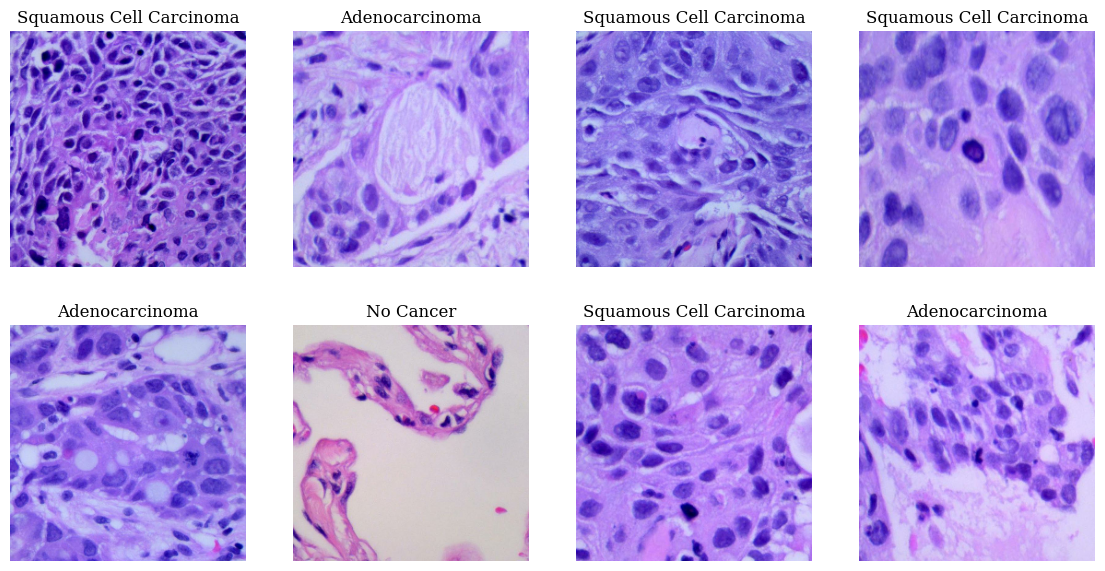

In [3]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [4]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

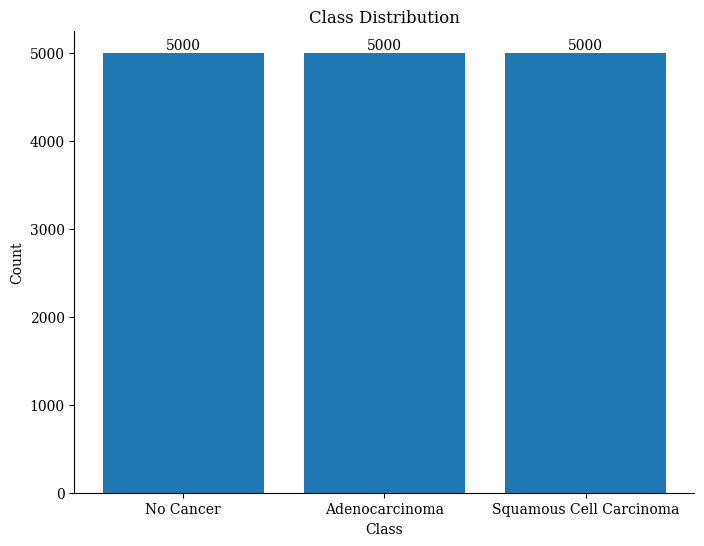

In [5]:
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)

plt.figure(figsize=(8, 6))
barplot = plt.bar(class_details, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Add count labels on top of the bars
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha="center", va="bottom")

plt.show()

In [6]:
prerained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,739,594
Trainable params: 164,355
Non-trainable params: 6,575,239
_________________________________________________________________


1/1 [==============================] - 4s 4s/step


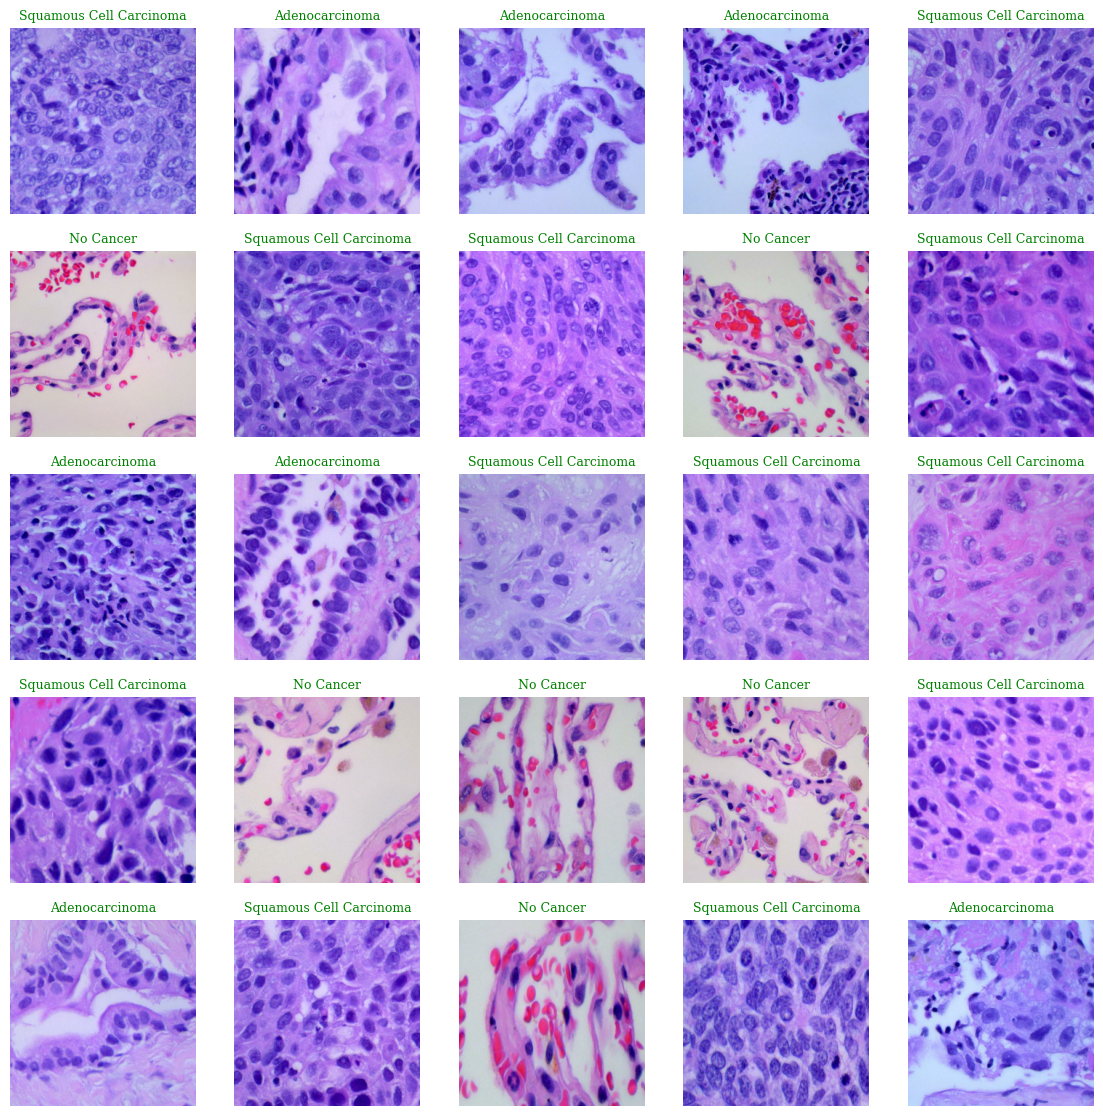

In [7]:
# Recreate the model with the same architecture
loaded_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,  # Reuse the pretrained base
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Load the model weights from the first notebook
loaded_model.load_weights("efficientnet_model_weights.h5")

# Compile the loaded model
loaded_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Now, you can use the loaded model for inference and visualization
result = loaded_model.predict(validation_ds)

# Call your visualization function (e.g., plot_predictions) using the loaded_model
plot_predictions(loaded_model)

In [10]:
import tensorflow as tf
import gradio as gr
import numpy as np
import cv2

# Assuming 'loaded_model' is defined and loaded elsewhere in your code
# Define your 'predict_image' function as follows:

def predict_image(img):
    print("Predicting image...")
    
    # Resize the image to (256, 256) and convert to a 3D array
    img_copy = img.copy()
    img_3d = cv2.resize(img_copy, (256, 256))
    img_3d = np.array(img_3d).reshape(-1, 256, 256, 3)

    # Load your model here (replace 'loaded_model' with your loaded model)
    prediction = loaded_model.predict(img_3d)[0]

    class_labels = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction)
    
    if predicted_class_index < len(class_labels):
        predicted_class = class_labels[predicted_class_index]
        confidence_percentage = prediction[predicted_class_index] * 100
        if confidence_percentage >= 99.5:
            return f"{predicted_class} (Confidence: {confidence_percentage:.2f}%)"
        else:
            return "Wrong Image"
    else:
        return "Wrong Image"

image = gr.inputs.Image(shape=(250, 250))
label = gr.outputs.Label()

gr.Interface(fn=predict_image, inputs=image, outputs=label, debug=True).launch()


C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Jess John\AppData\Local\Temp\ipykernel_1212\2263006563.py:35: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(250, 250))
C:\Users\Jess John\AppData\Local\Temp\ipykernel_1212\2263006563.py:35: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(250, 250))
C:\Users\Jess John\AppData\Local\Temp\ipykernel_1212\2263006563.py:36: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
C:\Users\Jess John\AppData\Local\Te

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Predicting image...
1/1 [==============================] - 1s 1s/step
Predicting image...
1/1 [==============================] - 0s 89ms/step
Predicting image...
1/1 [==============================] - 0s 90ms/step
Predicting image...
1/1 [==============================] - 0s 90ms/step
